In this study, there were 18 patients with cystic fibrosis.  The hypothesis was that there were two main communities at play in the CF lung.  One of these communities thrives at low pH, and the other community thrives at high pH.  To test this, sputum samples were divided among 8 tubes, and each of the tubes was perturbed with a different pH.  Here we will calculate balances, and test how these balances change with respect to pH, using linear mixed effects models.

First we'll want to load up the datasets we want to process into qiime

In [1]:
!qiime tools import --input-path otu_table.biom \
                    --output-path cfstudy.biom.qza \
                    --type FeatureTable[Frequency]

Then we'll want to drop all of the samples that do not have pH values.  Most of the samples that don't have these
values are blanks.  The healthy individuals will not be included either, since we are explicitly looking at the effects of pH on cystic fibrosis lungs.

In [2]:
import pandas as pd
import numpy as np
import qiime2
from gneiss.util import match
np.random.seed(10) # make sure that these results are consistent
mapping = pd.read_table('cfstudy_metadata.txt', index_col=0)
# Drop sputum samples
mapping = mapping.dropna(subset=['ph']) 
# Drop healthy samples
mapping = mapping.loc[mapping.healthy=='No']
# Drop samples without ph.  This will drop blanks
mapping = mapping.loc[mapping.ph != 'Not applicable']
mapping['ph'] = mapping.ph.astype(np.float64)
# Drop samples not in the OTU table
table = qiime2.Artifact.load('cfstudy.biom.qza')
otu_table = table.view(pd.DataFrame)
_, mapping = match(otu_table, mapping)
mapping.to_csv('cfstudy_modified_metadata.txt', sep='\t')

We'll try to throw the samples without pH measurements.

In [3]:
!qiime feature-table filter-samples \
                   --i-table cfstudy.biom.qza \
                   --m-sample-metadata-file cfstudy_modified_metadata.txt \
                   --o-filtered-table cfstudy_common.biom.qza

Saved FeatureTable[Frequency] to: cfstudy_common.biom.qza


Again, we'll want to filter out low abundance OTUs.  This will not only remove potential confounders, but could also alleviate the issue with zeros. 

In [4]:
!qiime feature-table filter-features \
                    --i-table cfstudy_common.biom.qza \
                    --o-filtered-table cfstudy_common_filt500.biom.qza \
                    --p-min-frequency 500

Saved FeatureTable[Frequency] to: cfstudy_common_filt500.biom.qza


Again, we will create the tree using pH.  Note that we'll also want to reorder the OTU table for the balance calculations.

In [5]:
!qiime gneiss gradient-clustering \
                    --i-table cfstudy_common_filt500.biom.qza \
                    --m-gradient-file cfstudy_modified_metadata.txt \
                    --m-gradient-category ph \
                    --o-clustering ph_tree.nwk.qza \
                    --p-weighted

Saved Phylogeny[Rooted] to: ph_tree.nwk.qza


Before running the linear mixed effects models using mixed we'll want to replace zeros with a pseudocount to approximate the uncertainity probability.

In [6]:
!qiime composition add-pseudocount \
                    --i-table cfstudy_common_filt500.biom.qza \
                    --p-pseudocount 1 \
                    --o-composition-table cf_composition.biom.qza

Saved FeatureTable[Composition] to: cf_composition.biom.qza


Now we can run the linear mixed effects models. pH is the only covariate being tested for and each of the patients are being accounted for by passing host_subject_id into groups.  This is because the microbial differences between the patients are much larger than the pH effects, so we need to correct for this change, by treating each patient separately.  This is why the linear mixed effects strategy is chosen.

In [7]:
!qiime gneiss lme-regression \
                    --p-formula "ph" \
                    --i-table cf_composition.biom.qza \
                    --i-tree ph_tree.nwk.qza \
                    --m-metadata-file cfstudy_modified_metadata.txt \
                    --p-groups host_subject_id \
                    --o-linear-mixed-effects-model cf_linear_mixed_effects_model.qza

Saved LinearMixedEffects_g to: cf_linear_mixed_effects_model.qza


Let's summarize the results of the linear mixed effects model.

In [8]:
!qiime gneiss lme-summary \
                    --i-model cf_linear_mixed_effects_model.qza \
                    --o-visualization cfstudy_summary

Saved Visualization to: cfstudy_summary.qzv


These summary results can be visualized in qiime2 visualization framework.  Checkout [view.qiime2.org](view.qiime2.org)

Like before, let's investigate the datasets more carefully.

In [9]:
from gneiss.regression import LMEModel
# Load the artifacts
model = qiime2.Artifact.load('cf_linear_mixed_effects_model.qza')
table = qiime2.Artifact.load('cfstudy_common_filt500.biom.qza')
# View the artifacts as more familiar objects
otu_table = table.view(pd.DataFrame)
lme_model = model.view(LMEModel)

We will visualize the entire tree, and resize the internal nodes reflect the pvalues with respect to ph.
Specifically, we want to test to determine if pH is a driving factor. 

We also want to visualize the mean ph values for each OTU and load the tree.

In [10]:
from gneiss.sort import mean_niche_estimator
t = lme_model.tree
mean_ph = mean_niche_estimator(otu_table, mapping.ph)

Then we'll want to populate the tree with attributes that we would like to visualize.

In [11]:
for n in t.postorder():
    n.color = '#FF00FF'  # color all nodes magenta    
    if n.is_tip():       # display mean ph in hover tool
        n.mean_ph = mean_ph.loc[n.name]         
    else:                # resize node by pvalue
        pval = lme_model.pvalues.loc[n.name, 'ph']
        n.ph_pvalue = -np.log(pval) / 10        
    # color left edges green and right edges red
    if not n.is_root() and n.name == n.parent.children[0].name:
        n.edge_color = '#00FF00'  # left child is green
    elif not n.is_root():
        n.edge_color = '#FF0000'  # right child is red

Now we can specify the machinery to visualize the plots.

In [12]:
from gneiss.plot import radialplot
from bokeh.io import show, output_notebook
output_notebook()
p = radialplot(t, node_size='ph_pvalue', 
               node_color='color', edge_color='edge_color',
               hover_var='mean_ph')
show(p)

Loading BokehJS ...

Of course, we'll want to validate these findings by investigating the raw balances.  We'll look at the top two most significant balances `y0` and `y1`.

In [13]:
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
data = pd.merge(lme_model.balances, mapping, left_index=True, right_index=True)

We'll plot the how the top balance change with respect to the pH.  Each patient will have their own unique color.

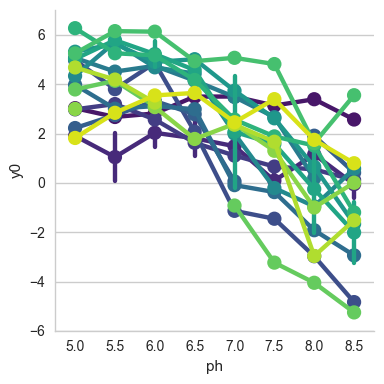

In [14]:
grid = sns.factorplot(x="ph", y="y0", hue='host_subject_id', 
                      data=data, palette="viridis", legend=False) 

Similar to the 88soils example, there is a very obvious transition from low pH organisms to high pH organism as the pH incrases.  However, given that every patient has different microbes, so it is difficult to test for individual microbes abundances across patients.  However, every patient has microbes that behave the same with respect to pH.  Balances is a very powerful tool for addressing this, as it can allow for entire subcommunities to be tested, rather than just individual OTUs.